### Custom Dataset class for working with the patched images/masked from disk

In [11]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, sampler
from torch import nn
import matplotlib.pyplot as plt
from torchmetrics.classification import BinaryJaccardIndex
from torch.utils.tensorboard import SummaryWriter

from rasterio.plot import show

In [6]:
len(set(polygons.centroid_of_tile))

64

In [2]:
file.sort_values(by=['avg_jaccard_idx'], ascending=False)

,Config_name,avg_jaccard_idx
15,timm-resnest14d_imagenet_sigmoid,36.303306
19,vgg16_imagenet_sigmoid,36.006037
11,resnet18_imagenet_sigmoid,19.580948
13,resnet18_None_sigmoid,13.983438
17,timm-resnest14d_None_sigmoid,10.457010
21,vgg16_None_sigmoid,2.202643
3,resnet18_None_None,1.076990
0,resnet18_imagenet_sigmoid,1.018697
22,vgg16_None_None,0.993818
7,timm-resnest14d_None_None,0.982416


In [2]:
class GeoImageDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_files = os.listdir(self.img_dir)
        self.mask_files = os.listdir(self.mask_dir)
        self.transform = transform
        

    def __len__(self):
        return len(self.img_files)
        
    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        # mask and img_file have so far the same name
        mask_path = os.path.join(self.mask_dir, self.img_files[idx])
        img = torch.load(img_path)
        # converts bool mask into integer (0/1)
        mask = torch.load(mask_path).long()
        # Apply transform (if any)
        if self.transform:
            img = self.transform(img)
        
        return img, mask

In [3]:
img_dir = r'C:\Users\Fabian\Documents\Masterarbeit_Daten\images_only_AOI'
mask_dir = r'C:\Users\Fabian\Documents\Masterarbeit_Daten\masks_only_AOI'
geo_image_dataset = GeoImageDataset(img_dir, mask_dir)

In [150]:
def show_rgb_sample(sample):
    img, mask = sample
    plt.figure(figsize=(8, 8))
    plt.imshow(torch.Tensor.numpy(img[1:4,:,:]).transpose((1,2,0)))
    plt.imshow(torch.Tensor.numpy(mask), 'jet', alpha=0.4*(torch.Tensor.numpy(mask)==True))

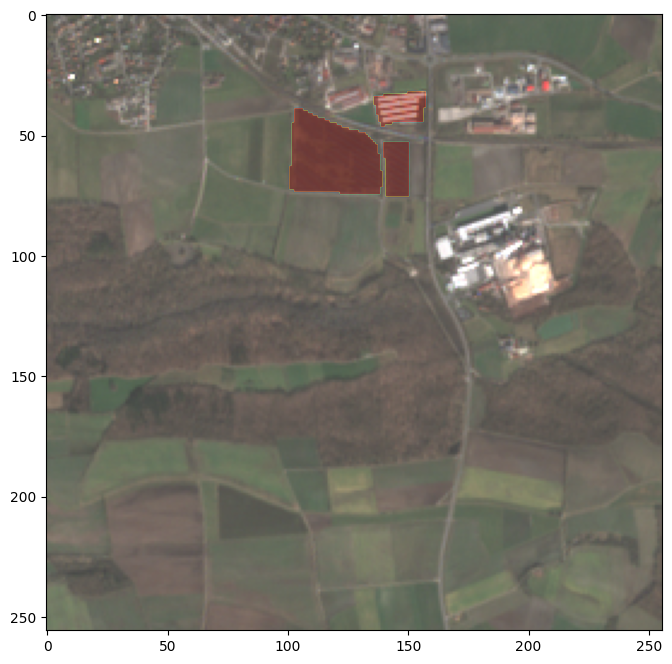

In [151]:
show_rgb_sample(geo_image_dataset[144])

In [4]:
# train test split
train_ds, test_ds = torch.utils.data.random_split(geo_image_dataset, [0.8, 0.2])

In [5]:
# load train test data
train_dataloader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=32, shuffle=True)

In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


https://smp.readthedocs.io/en/latest/quickstart.html

In [7]:
import segmentation_models_pytorch as smp
# select Unet with resnet34 as backbone
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=4,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
    #activation='sigmoid', 
).cuda()

# improves model with PyTorch 2.0 enhancements
#model = torch.compile(model)

In [9]:
from segmentation_models_pytorch.encoders import get_preprocessing_fn

preprocess_input = get_preprocessing_fn('resnet18', pretrained='imagenet')

In [8]:

# CrossEntropyLoss is the best for binary classification
#loss_fn = nn.CrossEntropyLoss()
#loss_fn =  nn.BCELoss() #nn.BCEWithLogitsLoss()
loss_fn = smp.losses.JaccardLoss(mode='binary')
# check different optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [10]:
for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)
    break

In [11]:
pred.shape

torch.Size([32, 1, 256, 256])

In [35]:
pred.squeeze(1).shape

torch.Size([32, 256, 256])

In [38]:
y.shape

torch.Size([32, 256, 256])

In [13]:
loss_fn(pred.squeeze(1), y.to(torch.float32))

tensor(0.5383, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [14]:
pred[0]

tensor([[[-0.0284,  0.6253, -0.1013,  ..., -0.2761,  0.1613,  0.2122],
         [-0.3286,  0.8048,  0.9948,  ..., -0.2655, -0.6411, -1.0590],
         [-0.4132, -0.0840,  0.5041,  ...,  0.4415, -0.4476, -1.8598],
         ...,
         [ 0.5154, -0.5197,  0.3449,  ..., -1.0604, -0.5477, -0.6782],
         [ 0.2749, -0.1113,  0.4908,  ..., -0.5106, -0.2212, -0.6332],
         [-0.1555, -0.8275, -0.4220,  ..., -0.1365,  0.2082, -0.6432]]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [25]:
pred = pred.detach().cpu().numpy()

In [16]:
np.random.rand(3,3)

NameError: name 'np' is not defined

In [12]:
writer = SummaryWriter(log_dir=r'')

In [15]:
show(pred[3]>0.5)

TypeError: view() received an invalid combination of arguments - got (type), but expected one of:
 * (torch.dtype dtype)
      didn't match because some of the arguments have invalid types: (!type!)
 * (tuple of ints size)
      didn't match because some of the arguments have invalid types: (!type!)


In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred.squeeze(1), y.to(torch.float32))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred.squeeze(1), y.to(torch.float32)).item()
            metric = BinaryJaccardIndex().to(device)

            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Jaccard-Index: {(100*metric(pred.squeeze(1), y)):>0.5f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
epochs = 5
model_dir = r'C:\Users\Fabian\Documents\Masterarbeit_Daten\saved_models'
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    if (t+1) % 5 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'Jaccard_epoch-{}.pth'.format(t+1)))
print("Done!")

Epoch 1
-------------------------------
loss: 0.989609  [   32/  706]
Test Error: 
 Jaccard-Index: 1.03976%, Avg loss: 0.990223 

Epoch 2
-------------------------------
loss: 0.991964  [   32/  706]
Test Error: 
 Jaccard-Index: 0.86199%, Avg loss: 0.990288 

Epoch 3
-------------------------------
loss: 0.993238  [   32/  706]
Test Error: 
 Jaccard-Index: 1.36230%, Avg loss: 0.989789 

Epoch 4
-------------------------------
loss: 0.990182  [   32/  706]
Test Error: 
 Jaccard-Index: 1.06631%, Avg loss: 0.990059 

Epoch 5
-------------------------------
loss: 0.993270  [   32/  706]
Test Error: 
 Jaccard-Index: 0.95793%, Avg loss: 0.990193 

Done!


In [5]:
model_dir = r'C:\Users\Fabian\Documents\Masterarbeit_Daten\saved_models'
model_filename = 'BCELoss_epoch-10.pth'
model_path = os.path.join(model_dir, model_filename)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [6]:
model.eval() # enabling the eval mode to test with new samples.

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [113]:
inputs = geo_image_dataset[0][0].unsqueeze(0)
inputs = inputs.to(device)

In [12]:
img, mask = geo_image_dataset[144]
img = img.to(device)
mask = mask.to(device)

In [83]:
img.squeeze(1).shape

torch.Size([4, 256, 256])

In [15]:
# Run forward pass
with torch.no_grad():
  pred = model(img.unsqueeze(0))

In [17]:
pred.shape

torch.Size([1, 1, 256, 256])

In [34]:
mask.unsqueeze(0).shape

torch.Size([1, 256, 256])

In [46]:
mask

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')

In [47]:
pred

array([[[[0.4639978 , 0.25217748, 0.41824642, ..., 0.4641665 ,
          0.44168928, 0.20863271],
         [0.36252725, 0.11082934, 0.11363015, ..., 0.20572278,
          0.16195168, 0.08930285],
         [0.23569013, 0.11961476, 0.05646106, ..., 0.15686005,
          0.19348945, 0.17637464],
         ...,
         [0.08725852, 0.29687688, 0.03493158, ..., 0.18982275,
          0.25215122, 0.2280957 ],
         [0.23790587, 0.2560138 , 0.05892901, ..., 0.25709912,
          0.31481165, 0.28812566],
         [0.39574108, 0.37306482, 0.41304228, ..., 0.4101528 ,
          0.43770388, 0.42441863]]]], dtype=float32)

In [50]:
loss_fn(pred.squeeze(1), mask.to(torch.float32))

TypeError: 'int' object is not callable

In [18]:
metric = BinaryJaccardIndex().to(device)

NameError: name 'BinaryJaccardIndex' is not defined

In [53]:
100*metric(pred[:,0], mask.unsqueeze(0))

tensor(2.3570, device='cuda:0')

In [49]:
loss_fn = nn.BCELoss()

In [58]:
loss_fn(pred[:,0], mask.unsqueeze(0).to(torch.float32))

ValueError: Using a target size (torch.Size([256, 256])) that is different to the input size (torch.Size([1, 256, 256])) is deprecated. Please ensure they have the same size.

In [41]:
mask.unsqueeze(0).shape

torch.Size([1, 256, 256])

In [42]:
pred.shape

torch.Size([1, 2, 256, 256])

In [21]:
pred = pred.detach().cpu().numpy()

In [25]:
pred.shape

(1, 2, 256, 256)

In [27]:
pred[:,1].shape

(1, 256, 256)

In [28]:
mask.unsqueeze(0).numpy().shape

(1, 256, 256)

In [145]:
mask

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [29]:
loss_fn(pred[:,1], mask.unsqueeze(0).numpy())

TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [24]:
from rasterio.plot import show

In [30]:
pred.squeeze(0).squeeze(0).shape

(256, 256)

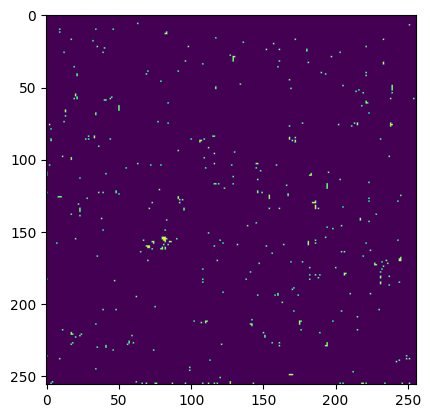

<Axes: >

In [36]:
show(pred.squeeze(0).squeeze(0)>0.5)

In [138]:
pred[0,1].min()

0.003713643

In [40]:
geo_image_dataset[0][0].unsqueeze(0).shape

torch.Size([1, 4, 256, 256])

In [58]:
img = torch.Tensor.numpy(geo_image_dataset[144][0].unsqueeze(0))
mask = torch.Tensor.numpy(geo_image_dataset[144][1].unsqueeze(0))

In [47]:
geo_image_dataset[0][0].shape

torch.Size([4, 256, 256])

In [45]:
img[0].shape

(4, 256, 256)

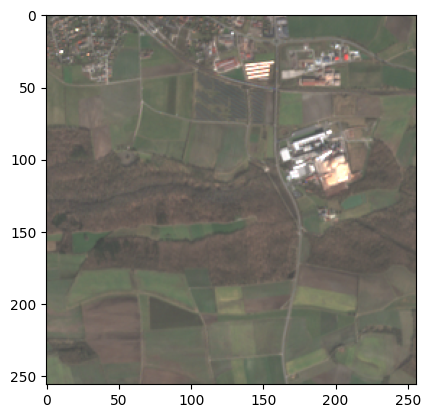

<Axes: >

In [59]:
show(img[0, 1:4])

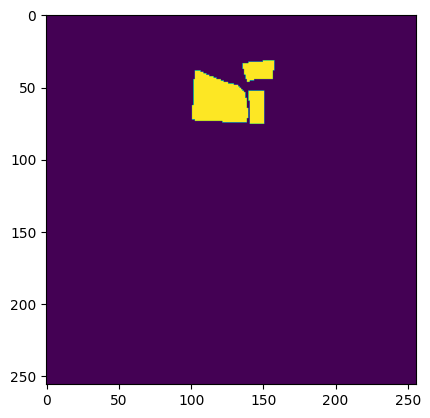

<Axes: >

In [60]:
show(mask)

In [69]:
with torch.no_grad():
    prediction = model(geo_image_dataset[0][0].unsqueeze(0).to(device))

In [19]:
geo_image_dataset[0][0].unsqueeze(0).shape

torch.Size([1, 4, 256, 256])

TypeError: Invalid shape (2, 256, 256) for image data

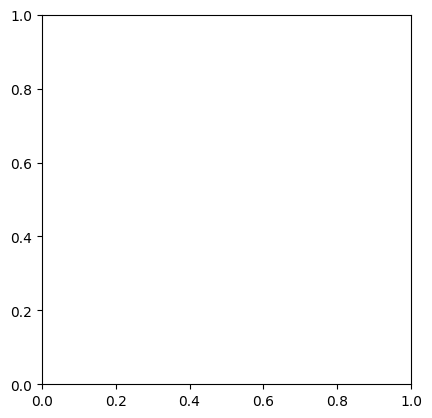

In [87]:
import matplotlib.pyplot as plt
plt.imshow(torch.Tensor.numpy(prediction[0].cpu()))